# imports

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.append('/mnt/home/cmodi/.local/lib/python3.8/site-packages/')

In [3]:
import sbi
import torch

In [4]:
import sys, os
sys.path.append('../src/')

import loader_pk
import sbitools, sbiplots

In [5]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# SNPE with matter spectra

In [79]:
args = {"kmin": 0.01, "kmax":0.5, "offset_amp":0, "ampnorm":False}
args = sbitools.Objectify(args)
kcut, features, params = loader_pk.loader(args, return_k=True)

Loaded power spectrum data with shape :  (2000, 128)
pk shape after k-cuts :  (2000, 78)


In [172]:
params[0]

array([0.1755 , 0.06681, 0.7737 , 0.8849 , 0.6641 ])

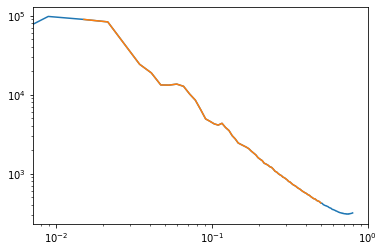

In [80]:
k, p = np.load('/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter/N0256/0000/power.npy').T
plt.plot(k, p)
plt.plot(kcut, features[0])
plt.loglog()
plt.show()


[]

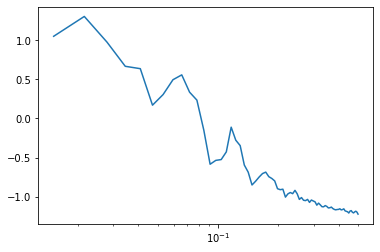

In [81]:
trainx, scaler = sbitools.standardize(features, secondary=None, log_transform=True)
trainy = params.copy()
plt.plot(kcut, trainx[0])
plt.semilogx()

In [82]:
### SBI

prior = sbitools.sbi_prior(params.reshape(-1, params.shape[-1]), offset=0.2)

posterior, inference, summary = sbitools.sbi(trainx, trainy, prior, \
                                            summarize=True,
                                            verbose=True, 
                                             nlayers=8)

Training a new NF
 Neural network successfully converged after 309 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 309
        Best validation performance: 14.2563
        -------------------------
        


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

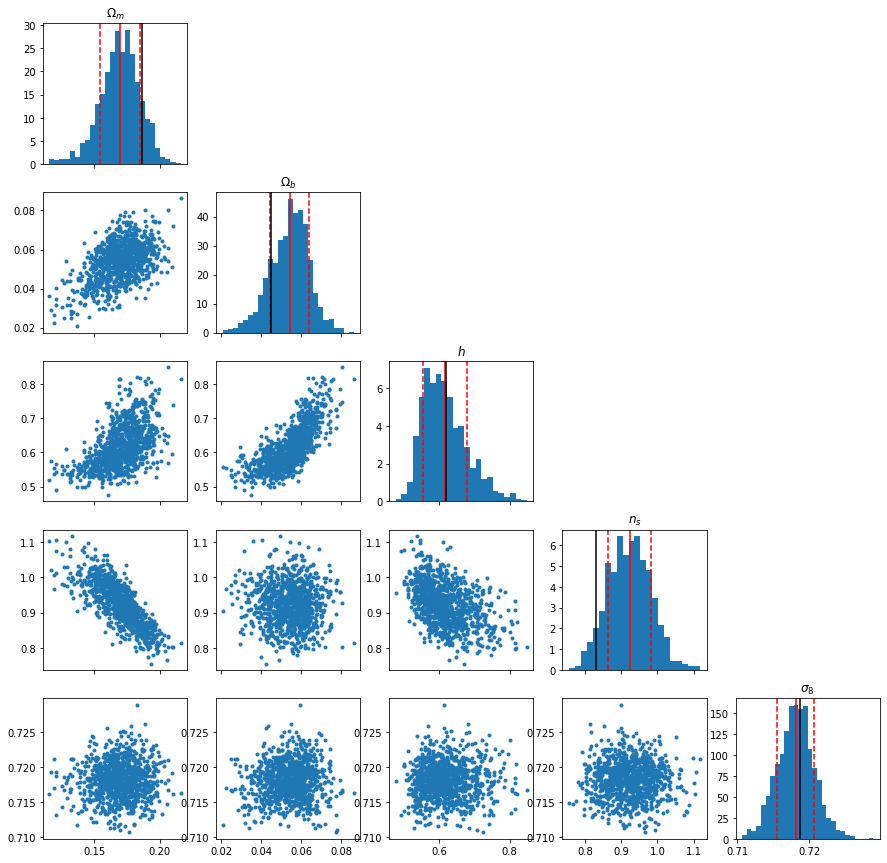

In [83]:
i = 2 
fig, ax = sbiplots.plot_posterior(trainx[i], trainy[i], posterior)

In [84]:
nsims, nsamples = 100, 1000
samples = np.zeros([nsims, nsamples, params.shape[1]])
for j in range(100):
    x = trainx[j].copy()
    samples[j] = posterior.sample((nsamples,), x=torch.from_numpy(x.astype('float32')), show_progress_bars=False).detach().numpy()

    

<ErrorbarContainer object of 3 artists>

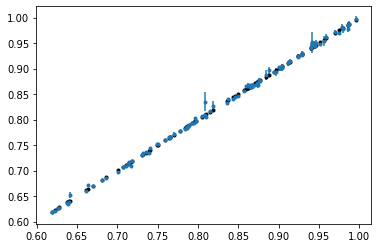

In [85]:
j = 4
plt.plot(params[:nsims, j], params[:nsims, j], 'k.')
plt.errorbar(params[:nsims, j], samples.mean(axis=1)[:, j], samples.std(axis=1)[:, j], fmt='.')



# SNLE with matter spectra

In [31]:
from sbi.inference import SNLE_A
from sbi.utils.get_nn_models import posterior_nn, likelihood_nn


In [19]:
args = {"kmin": 0.01, "kmax":0.5, "offset_amp":0, "ampnorm":False}
args = sbitools.Objectify(args)
kcut, features, params = loader_pk.loader(args, return_k=True)
trainx, scaler = sbitools.standardize(features, secondary=None, log_transform=True)
trainy = params.copy()


Loaded power spectrum data with shape :  (2000, 128)
pk shape after k-cuts :  (2000, 78)


In [33]:
density_estimator_build_fun = likelihood_nn(model='maf', \
                                           hidden_features=32, \
                                           num_transforms=8,
                                           num_blocks=2)

inference = SNLE_A(prior=prior, density_estimator=density_estimator_build_fun)
inference.append_simulations(x= torch.from_numpy(trainx.astype('float32')),
                            theta= torch.from_numpy(trainy.astype('float32')))

density_estimator = inference.train(training_batch_size=16,
                                        validation_fraction=0.1,
                                        learning_rate=5e-4,
                                        show_train_summary=True)

posterior_nle = inference.build_posterior(density_estimator)



 Neural network successfully converged after 195 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 195
        Best validation performance: 152.8132
        -------------------------
        


In [155]:
j = 0 
nsamples = 500 
x = trainx[j].copy()
samples_nle = posterior_nle.sample((nsamples,), x=torch.from_numpy(x.astype('float32')), show_progress_bars=True).detach().numpy()


Tuning bracket width...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.35it/s]

Generating samples: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.89it/s]

Running 1 MCMC chains in 1 batches.: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [04:31<00:00, 271.62s/it]


In [99]:
# density_estimator.log_prob(torch.from_numpy(trainx[0].astype(np.float32)), context=torch.from_numpy(trainy[0].astype(np.float32)))
density_estimator.log_prob(torch.from_numpy(trainx[0].reshape(1, -1).astype(np.float32)), context=torch.from_numpy(trainy[0].reshape(1, -1).astype(np.float32)))

tensor([159.2676], grad_fn=<AddBackward0>)

In [123]:
density_estimator.log_prob(torch.from_numpy(trainx[0].reshape(1, -1).astype(np.float32)), context=torch.from_numpy(trainy[0].reshape(1, -1).astype(np.float32))) + prior.log_prob(torch.from_numpy(trainy[0].reshape(1, -1).astype(np.float32)))

tensor([162.9791], grad_fn=<AddBackward0>)

In [120]:
from sbi.inference import likelihood_estimator_based_potential
potential_fn, parameter_transform = likelihood_estimator_based_potential(
                                                                        density_estimator, 
                                                                        prior, 
                                                                        torch.from_numpy(trainx[0].reshape(1, -1).astype(np.float32)))

In [121]:
potential_fn(torch.from_numpy(trainy[0].reshape(1, -1).astype(np.float32)))

tensor([162.9791], grad_fn=<AddBackward0>)

In [159]:
import time

In [161]:
import zeus

def log_prob(x):
    return potential_fn(torch.from_numpy(x.reshape(1, -1).astype(np.float32))).detach().numpy()[0]
    # loglik =  density_estimator.log_prob(torch.from_numpy(y.reshape(1, -1).astype(np.float32)), context=torch.from_numpy(x.reshape(1, -1).astype(np.float32))).detach().numpy()[0]
    # logprior = prior.log_prob(torch.from_numpy(trainy[0].reshape(1, -1).astype(np.float32))).detach().numpy()[0]
    # return loglik + logprior
    
data = trainx[0].copy()
# x = trainy[99].copy()
nsteps, nwalkers, ndim = 1000, 20, 5
x0 = np.stack([trainy[np.random.randint(0, trainy.shape[0])] for _ in range(nwalkers)])
print(log_prob(trainy[0]))

start = time.time()
sampler = zeus.EnsembleSampler(nwalkers, ndim, log_prob)
sampler.run_mcmc(x0, nsteps, progress=False)
chain = sampler.get_chain(flat=True, discard=0.2);
print("Time taken = ", time.time() - start)

Initialising ensemble of 20 walkers...


162.97908
Time taken =  304.00113582611084


In [162]:
from sbi.inference import MCMCPosterior, RejectionPosterior

posterior1 = MCMCPosterior(potential_fn, proposal=prior, theta_transform=parameter_transform)
posterior2 = RejectionPosterior(potential_fn, proposal=prior)



In [171]:
samples1 = posterior1.sample((100,))
# samples2 = posterior2.sample((100,))

Tuning bracket width...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.05it/s]

Generating samples: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.87it/s]

Running 1 MCMC chains in 1 batches.: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:00<00:00, 60.50s/it]


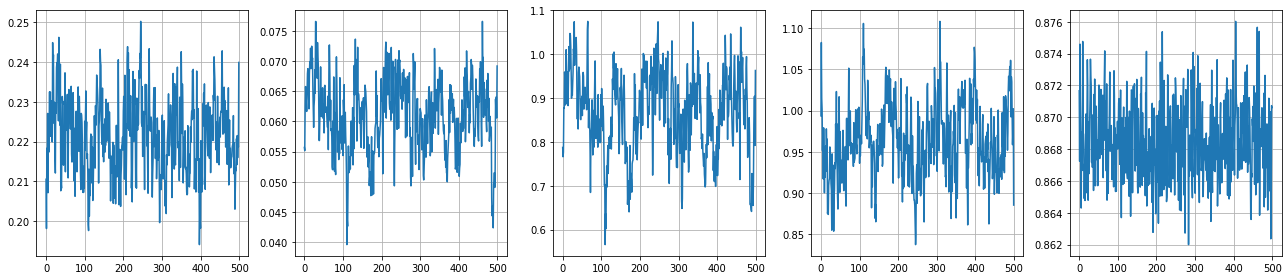

In [134]:
fig, ax = plt.subplots(1, 5, figsize=(18, 4))

for i in range(5):
    ax[i].plot(samples_nle[:, i])
    ax[i].grid(which='both')
plt.tight_layout()

In [139]:
chain.shape

(400, 10, 5)

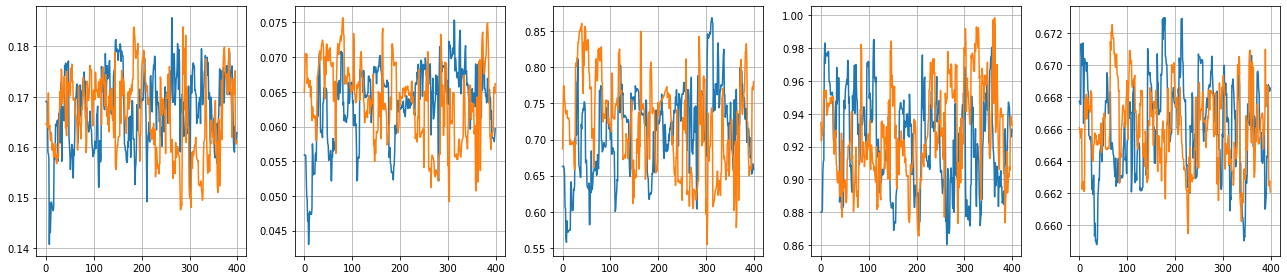

In [141]:
fig, ax = plt.subplots(1, 5, figsize=(18, 4))

for i in range(5):
    ax[i].plot(chain[:, 0, i])
    ax[i].plot(chain[:, 1, i])
    ax[i].grid(which='both')
plt.tight_layout()

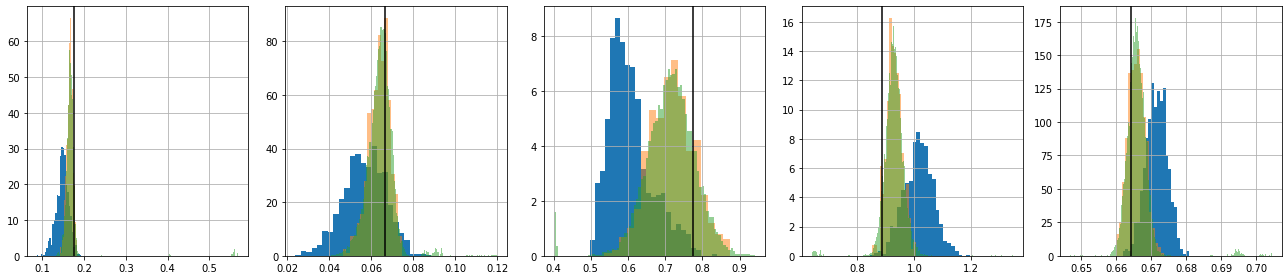

In [166]:
fig, ax = plt.subplots(1, 5, figsize=(18, 4))

j = 0 
for i in range(5):
    ax[i].hist(samples[j][:, i], density=True, bins='auto')
    ax[i].hist(samples_nle[:, i], alpha=0.5, density=True, bins='auto')
    ax[i].hist(chain[:, i], alpha=0.5, density=True, bins='auto')
    ax[i].axvline(params[j, i], color='k')
    ax[i].grid(which='both')
plt.tight_layout()

In [37]:
# sbiplots.plot_posterior(trainx[j].copy(), trainy[j].copy(), posterior_nle)

#  Sub boxes

In [174]:
from nbodykit.lab import FFTPower, ArrayMesh

In [152]:
f = np.load('/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter/N0256/0000/field.npy')
print(f.mean())

63.99999999999987


In [122]:
del x0, x1, y0, y1, z0, z1

0 128 0 128 0 128
63.51390101137236
0 128 0 128 128 256
64.65476435656491
0 128 128 256 0 128
64.13825436758009
0 128 128 256 128 256
64.73048446950413
128 256 0 128 0 128
64.47135666325836
128 256 0 128 128 256
63.1753033129009
128 256 128 256 0 128
65.43669744828962
128 256 128 256 128 256
61.87923837052953


[]

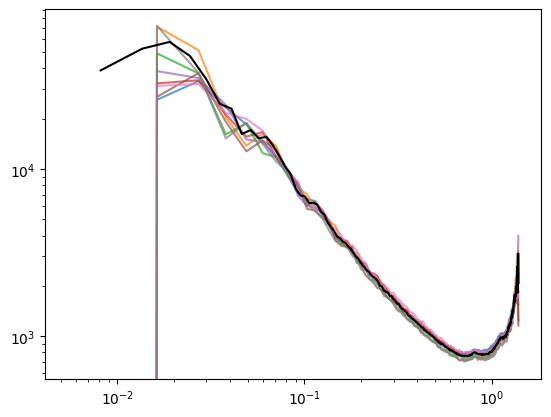

In [189]:
sys.path.append('../../galmodel/code/utils/')
import tools

kfull, pfull = tools.power(f/f.mean(), boxsize=1000)


# x0, x1 = 0, 128
# y0, y1 = 0, 128
# z0, z1 = 0, 128
fac = 2
nc = 256 // fac 
psubs = []
psubsnb = []
for i in range(fac):
    x0, x1 = nc*i, nc*(i+1)
    
    for j in range(fac):
        y0, y1 = nc*j, nc*(j+1)
    
        for ik in range(fac):
            z0, z1 = nc*ik, nc*(ik+1)            
            
            print(x0, x1, y0, y1, z0, z1)
            sub = f[x0:x1, y0:y1, z0:z1]
            box = sub*1.
            print(box.mean())
            ksub, psub = tools.power(box/box.mean(), boxsize=1000/fac)
            mesh = ArrayMesh(box/box.mean(), BoxSize=1000/fac)
            pk = FFTPower(mesh, mode='1d', dk=2*np.pi/1000, kmin=2*np.pi/1000*fac ).power
            psubsnb.append(pk['power'])
            plt.plot(ksub, psub, alpha=0.7)
            psubs.append(psub)

plt.plot(kfull[1:], pfull[1:], 'k')

plt.loglog()


In [ ]:
# nmodes = 4* pi * k[1:]**2 * np.diff(k) * bs **3 /(2*pi)**3  * 2 #/ bs**3 
# var = 2*np.interp(k[1:], khfit, pkhfit)**2 / nmodes
# err = var**0.5
# plt.plot(err)

# # plt.plot(k0, p0/np.interp(k, ktest, pkhfit))
# # plt.plot(k, p1/np.interp(k, ktest, pkhfit))
# erry = err/np.interp(k[1:], khfit, pkhfit)
# pden = lambda k : np.interp(k, khfit, pkhfit)


Text(0, 0.5, 'P$_{sub-vol: 500 Mpc/h}$(k)/P$_{full: 1 Gpc/h}$(k)')

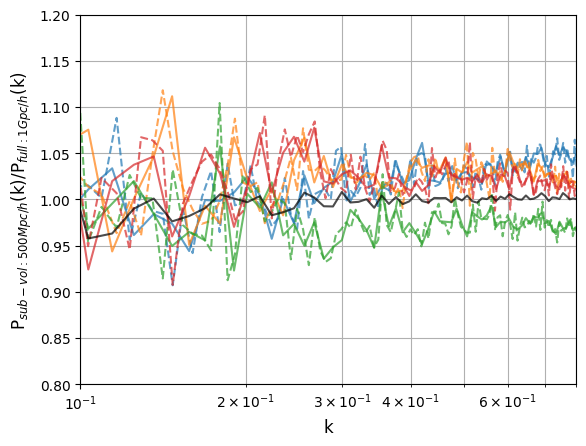

In [190]:
# nmodes_sub = 4* pi * k[1:]**2 * np.diff(k) * (bs/fac) **3 /(2*pi)**3  * 2 #/ bs**3 
# var_sub = 2*np.interp(k[1:], kfull, pfull)**2 / nmodes_sub
# err_sub = var_sub**0.5
# err_sub /= np.interp(ksub[1:], kfull, pfull)

# for i in range(fac**3):
for i in range(4):
    # plt.errorbar(ksub[1:], psub[1:]/np.interp(ksub[1:], kfull, pfull), err_sub, alpha=0.7)
    plt.errorbar(ksub[1:], psubs[i][1:]/np.interp(ksub[1:], kfull, pfull), color=f'C{i}', alpha=0.7)
    plt.errorbar(pk['k'][1:], psubsnb[i][1:]/np.interp(pk['k'][1:], kfull, pfull), color=f'C{i}', alpha=0.7, ls='--')

plt.errorbar(ksub, np.array(psubs).mean(axis=0)/np.interp(ksub, kfull, pfull),  color='k', alpha=0.7)
# plt.plot(ksub, psub2/np.interp(ksub, kfull, pfull))
plt.semilogx()
plt.grid(which='both')
plt.ylim(0.8, 1.2)
plt.xlim(0.1, 0.8) 

plt.xlabel('k', fontsize=12)
plt.ylabel('P$_{sub-vol: 500 Mpc/h}$(k)/P$_{full: 1 Gpc/h}$(k)', fontsize=12)

[]

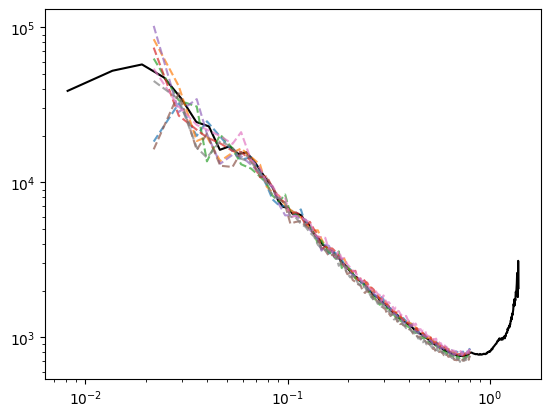

In [216]:
# for i in range(fac**3):
plt.plot(kfull[1:], pfull[1:], 'k-')
for i in range(8):
    # plt.errorbar(ksub[1:], psub[1:]/np.interp(ksub[1:], kfull, pfull), err_sub, alpha=0.7)
    # plt.errorbar(ksub[1:], psubs[i][1:], color=f'C{i}', alpha=0.7)
    plt.errorbar(pk['k'][1:], psubsnb[i][1:], color=f'C{i}', alpha=0.7, ls='--')
plt.loglog()

In [116]:
# # WITH ZERO PADDING
# psubs2 = []
# for i in range(2):
#     x0, x1 = nc*i, nc*(i+1)
    
#     for j in range(2):
#         y0, y1 = nc*j, nc*(j+1)
    
#         for ik in range(2):
#             z0, z1 = nc*ik, nc*(ik+1)            
            
#             print(x0, x1, y0, y1, z0, z1)
#             sub = f[x0:x1, y0:y1, z0:z1]
#             box = np.zeros([nc*3, nc*3, nc*3])
#             box[nc:2*nc, nc:2*nc, nc:2*nc] = sub
#             ksub2, psub2 = tools.power(box, boxsize=1000/fac*3)
#             psub2 /= (3)**3
#             plt.plot(ksub2, psub2, alpha=0.7)
#             psubs2.append(psub2)

# plt.plot(kfull[1:], pfull[1:], 'k')

# plt.loglog()
# plt.show()

# for psub2 in psubs2[:8]:
#     plt.errorbar(ksub2[1:], psub2[1:]/np.interp(ksub2[1:], kfull, pfull), alpha=0.7)

# plt.errorbar(ksub, np.array(psubs).mean(axis=0)/np.interp(ksub, kfull, pfull),  color='k', alpha=0.7)
# # plt.plot(ksub, psub2/np.interp(ksub, kfull, pfull))
# plt.semilogx()
# plt.grid(which='both')
# plt.ylim(0.8, 1.2)
# plt.xlim(0.1, 0.8) 

# plt.xlabel('k', fontsize=12)
# plt.ylabel('P$_{sub-vol: 500 Mpc/h}$(k)/P$_{full: 1 Gpc/h}$(k)', fontsize=12)

[]

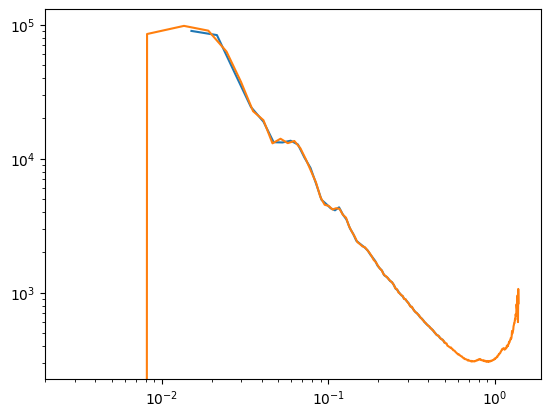

In [117]:
plt.plot(kcut, features[0])
plt.plot(kfull, pfull)
plt.loglog()

[]

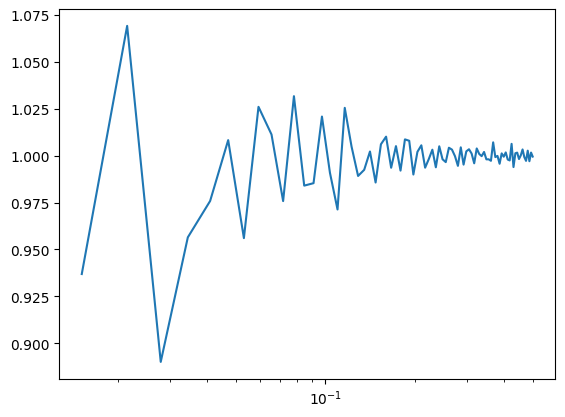

In [120]:
plt.plot(kcut, features[0]/np.interp(kcut, kfull, pfull))
plt.semilogx()

[]

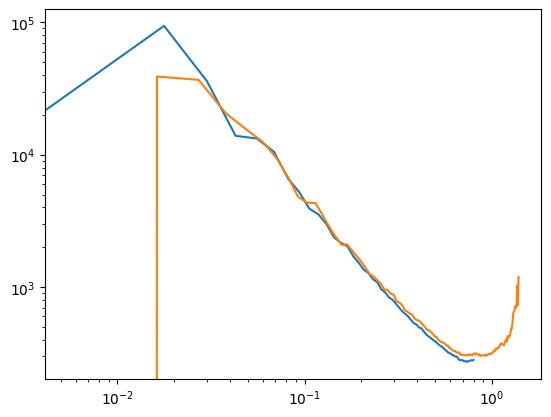

In [160]:
plt.plot(pk['k'], pk['power'])
plt.plot(ksub, psubs[0])
plt.loglog()

In [172]:
!ls /mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter/N0256/0000

field.npy  power.npy


## loop over LH

In [ ]:
def get_pksubs(f, fac=2, zeropad = False):

    nc = f.shape[0] // fac 
    psubs = []
    for i in range(fac):
        x0, x1 = nc*i, nc*(i+1)

        for j in range(fac):
            y0, y1 = nc*j, nc*(j+1)

            for ik in range(fac):
                z0, z1 = nc*ik, nc*(ik+1)            

            
                sub = f[x0:x1, y0:y1, z0:z1]
                if zeropad:
                    box = np.zeros([nc*3, nc*3, nc*3])
                    box[nc:2*nc, nc:2*nc, nc:2*nc] = sub
                    ksub2, psub2 = tools.power(box, boxsize=1000/fac*3)
                    psub2 /= (3)**3
                else:
                    box = sub*1.
                    mesh = ArrayMesh(box/box.mean(), BoxSize=1000/fac)
                    pk = FFTPower(mesh, mode='1d', dk=2*np.pi/1000, kmin=2*np.pi/1000*fac ).power
                psubs.append(pk['power'])
    psubs = np.array(psubs)
    return pk['k'], psubs


fac = 4
for i in range(2000):
    if (i%50 == 0):print(i)
    f = np.load(f'/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter/N0256/{i:04d}/field.npy')
    ksubs, psubs = get_pksubs(f, fac=fac)
    # print(psubs.shape)
    np.save(f'/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter/N0256/{i:04d}/power_split{fac}.npy', psubs)
    np.save(f'/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter/N0256//k_split{fac}.npy', ksubs)


0
50
100
150


In [227]:
((kfull > 0.1) & (kfull < 0.5)).sum() #, ksub


74

In [228]:
((ksub > 0.1) & (ksub < 0.5)).sum()


37

In [229]:
((pk['k'] > 0.1) & (pk['k'] < 0.5)).sum()


64

In [231]:
p0 = np.load('/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter/N0256/0000/power.npy')
p1 = np.load('/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter/N0256/0000/power_split4.npy')
k1 = np.load('/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter/N0256/k_split4.npy')


[]

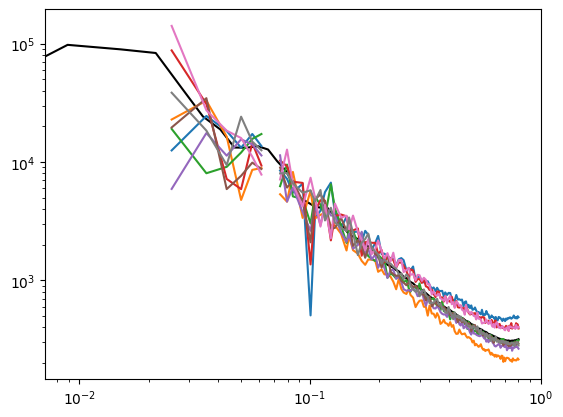

In [233]:
plt.plot(p0[..., 0], p0[..., 1], 'k-')
for i in range(8):
    plt.plot(k1, p1[i])
plt.loglog()
